In [130]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import resnet50, ResNet50_Weights

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Section 1: Data Loading + Preprocessing

The functions in this section are taken from [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) Pytorch tutorial.

In [3]:
# define the transform object to be applied to each image in the dataset
transform = transforms.Compose(
    [
        # convert to a PyTorch tensor
        transforms.ToTensor(),
        
        # normalize the image tensor by subtracting the mean and 
        # dividing by the standard deviation 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# set the batch size
batch_size = 4

# load CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform # apply the transform to each image in the dataset
)

# split training set into batches of size batch_size 
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, # Shuffle the training set before each epoch
    num_workers=2 # number of worker threads to use for loading the data
)

# load the CIFAR10 test set
testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform # apply the transform to each image
)

# split the test set into batches of size batch_size 
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2 # number of worker threads to use
)

# the 10 categories in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


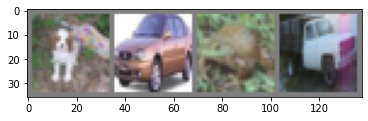

dog   car   frog  truck


In [146]:
def imshow(img):
    """
    Display a PyTorch tensor as an image using matplotlib
    """
    # unnormalize the image 
    img = img / 2 + 0.5
    npimg = img.numpy()
    
    # transpose numpy array from CxHxW to HxWxC format and display image 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display the batch
imshow(torchvision.utils.make_grid(images))

# print the labels for each image 
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Fixed hyperparameters

I will use a fixed set of hyperparameters, including a learning rate of 0.002, momentum of 0.9 for the PyTorch SGD function, and four epochs for training each model. While tuning hyperparameters for each model can improve accuracy, using a fixed set allows for easier comparison of model effectiveness. Since comparing models is what I want to do in this assignment, using fixed hyperparameters is necessary.

However, it is important to note that using fixed hyperparameters may not result in the most optimized models for each architecture, and tuning hyperparameters could potentially improve the models' performances.

In [38]:
lr = 0.002
momentum = 0.9
epochs = 4

## Section 2: Linear Classifier
-------------------------------------------------
Perform the following tasks and report the differences

- Implement a linear classifier to classify CIFAR-10. 
- Try multiple regression methods, such as: softmax, logistic, +1vs1/1vsAll, etc.
- Train linear classifiers with the bias term and without: $y = Wx$ vs $y = Wx + b$
- Train models with a single linear layer and with multiple

In [1]:
# helpful later
input_dim = 3 * 32 * 32
output_dim = 10

A few functions we will use later on:

In [149]:
def trainer(model, criterion, optimizer, n_epoch=epochs): 
    """
    inspired by pytorch tutorial linked in section 1
    """
    start = time.perf_counter() 
    loss_history = []

    # move model to device
    model = model.to(device)
    # move loss function to device
    criterion = criterion.to(device)
    for epoch in range(n_epoch):  # loop over dataset n_epoch times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # unpack inputs and labels from data
            inputs, labels = data
            # move input data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero gradient accumulation 
            optimizer.zero_grad()
            # compute forward pass 
            outputs = model(inputs)
            # compute the loss between the predicted outputs and actual labels
            loss = criterion(outputs, labels)
            # backpropagate
            loss.backward()
            # update the model parameters
            optimizer.step()
            # accumulate running loss
            running_loss += loss.item()
            # print average loss every 2000 mini-batches
            if i % 2000 == 1999:
                print(f'[Epoch {epoch + 1}, Mini-batch {i + 1:5d}] Loss: {running_loss / 2000:.3f}')
                loss_history.append(running_loss / 2000)
                running_loss = 0.0    
    end = time.perf_counter()
    # print training time
    print(f"Training time: {end - start:.6f} seconds")
    print("Training Complete!")
    return loss_history

In [150]:
def evaluate(model):
    """
    inspired by pytorch tutorial linked in section 1
    """
    model = model.to(device)  # move the model to device
    model.eval()  # set the model to eval mode

    # we don't need to calculate the gradients for our outputs in eval mode
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            # get images and corresponding labels from the test set
            images, labels = data
            images = images.to(device)  
            labels = labels.to(device)  

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

In [151]:
def plot_loss(loss_history):
    """
    plot average loss over the mini batches
    """
    fig, ax = plt.subplots(figsize=(16,8))
    x = np.arange(0, len(loss_history))
    
    ax.plot(x, loss_history)
    x_lim = ax.get_xlim()
    new_ticks = [x for x in range(int(x_lim[0]), int(x_lim[1] + 1))]
    new_labels = [str((x+1) * 2000) for x in new_ticks]
    ax.set_xticks(new_ticks)
    ax.set_xticklabels(new_labels)
    plt.title("Average Loss Per 2000 Mini Batches")
    plt.xlabel("Mini batch")
    plt.ylabel("Average Loss")
    plt.show()

### Logistic Regression

First, let's explore a simple logistic regression model:

In [152]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # apply linear transformation to data with bias term
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # flatten the input data
        x = torch.flatten(x, 1)
        # apply the linear transformation and apply sigmoid function 
        outputs = torch.sigmoid(self.linear(x))
        # return the predicted probabilities 
        return outputs

**What is this code doing?**

First, this code flattens the input, a mini batch of images, into a mini batch of 1d arrays. It then transforms the 1d arrays by multiplying the input matrix (dimensions=(batch size, input_dim)), by a weight matrix (dimension=(input_dim, output_dim)), resulting in a matrix of dimension of (batch_size, output_dim). Then, the bias term is added. 

The output matrix is passed to through the sigmoid function which maps values to the range [0, 1], which represents the predicted probability that the input belongs to the class.

#### Training time
Let's train the model... but first, *what is cross entropy loss and why did I choose it*?

Cross entropy loss helps train models to predict the probability of an input belonging to a class. In classification, we may want to predict the probability of an input belonging to each class, not just choose the most likely class. Cross entropy loss helps by measuring how different the predicted probabilities are from the true labels. This makes it a very useful loss function for classification problems. [Source](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e) 

In [153]:
LR = LogisticRegression()
criterion_lr = nn.CrossEntropyLoss()
optimizer_lr = optim.SGD(LR.parameters(), lr=lr, momentum=momentum)
loss1 = trainer(LR, criterion_lr, optimizer_lr)

[Epoch 1, Mini-batch  2000] Loss: 2.099
[Epoch 1, Mini-batch  4000] Loss: 2.054
[Epoch 1, Mini-batch  6000] Loss: 2.038
[Epoch 1, Mini-batch  8000] Loss: 2.026
[Epoch 1, Mini-batch 10000] Loss: 2.026
[Epoch 1, Mini-batch 12000] Loss: 2.028
[Epoch 2, Mini-batch  2000] Loss: 2.010
[Epoch 2, Mini-batch  4000] Loss: 2.004
[Epoch 2, Mini-batch  6000] Loss: 2.006
[Epoch 2, Mini-batch  8000] Loss: 2.009
[Epoch 2, Mini-batch 10000] Loss: 2.002
[Epoch 2, Mini-batch 12000] Loss: 1.995
[Epoch 3, Mini-batch  2000] Loss: 1.995
[Epoch 3, Mini-batch  4000] Loss: 1.990
[Epoch 3, Mini-batch  6000] Loss: 1.996
[Epoch 3, Mini-batch  8000] Loss: 1.993
[Epoch 3, Mini-batch 10000] Loss: 1.987
[Epoch 3, Mini-batch 12000] Loss: 1.987
[Epoch 4, Mini-batch  2000] Loss: 1.984
[Epoch 4, Mini-batch  4000] Loss: 1.987
[Epoch 4, Mini-batch  6000] Loss: 1.979
[Epoch 4, Mini-batch  8000] Loss: 1.979
[Epoch 4, Mini-batch 10000] Loss: 1.982
[Epoch 4, Mini-batch 12000] Loss: 1.976
Training time: 84.269357 seconds
Trainin

Evaluate model

In [154]:
evaluate(LR)

Accuracy of the network on the 10000 test images: 38.72 %


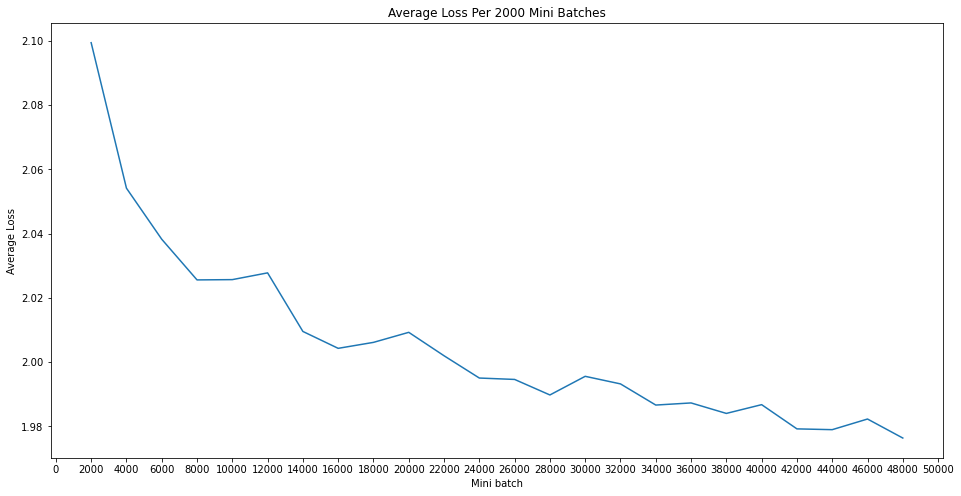

In [155]:
plot_loss(loss1)

### Logistic Regression... without a bias term???

Without a bias term, the decision boundary must pass through the origin. Thus, if the optimal hyperplane does not pass through the origin, then we will need a bias term to fit the data effectively.

In [156]:
class LRNoBias(nn.Module):
    def __init__(self):
        super(LRNoBias, self).__init__()
        # apply linear transformation to data with no bias term
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        # we need to flatten the data 
        x = torch.flatten(x, 1)
        # map elements to between 0 and 1
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [157]:
LR_wo_bias = LRNoBias()
criterion_lr_nobias = nn.CrossEntropyLoss()
optimizer_lr_nobias = optim.SGD(LR_wo_bias.parameters(), lr=lr, momentum=momentum)
loss7 = trainer(LR_wo_bias, criterion_lr_nobias, optimizer_lr_nobias)

[Epoch 1, Mini-batch  2000] Loss: 2.092
[Epoch 1, Mini-batch  4000] Loss: 2.052
[Epoch 1, Mini-batch  6000] Loss: 2.047
[Epoch 1, Mini-batch  8000] Loss: 2.040
[Epoch 1, Mini-batch 10000] Loss: 2.038
[Epoch 1, Mini-batch 12000] Loss: 2.029
[Epoch 2, Mini-batch  2000] Loss: 2.021
[Epoch 2, Mini-batch  4000] Loss: 2.017
[Epoch 2, Mini-batch  6000] Loss: 2.016
[Epoch 2, Mini-batch  8000] Loss: 2.012
[Epoch 2, Mini-batch 10000] Loss: 2.015
[Epoch 2, Mini-batch 12000] Loss: 2.015
[Epoch 3, Mini-batch  2000] Loss: 2.004
[Epoch 3, Mini-batch  4000] Loss: 2.002
[Epoch 3, Mini-batch  6000] Loss: 2.003
[Epoch 3, Mini-batch  8000] Loss: 2.012
[Epoch 3, Mini-batch 10000] Loss: 2.003
[Epoch 3, Mini-batch 12000] Loss: 2.005
[Epoch 4, Mini-batch  2000] Loss: 1.995
[Epoch 4, Mini-batch  4000] Loss: 2.000
[Epoch 4, Mini-batch  6000] Loss: 2.001
[Epoch 4, Mini-batch  8000] Loss: 2.004
[Epoch 4, Mini-batch 10000] Loss: 1.997
[Epoch 4, Mini-batch 12000] Loss: 2.000
Training time: 85.185293 seconds
Trainin

Let's evaluate the accuracy of our logistic regression model without a bias term:

In [158]:
evaluate(LR_wo_bias)

Accuracy of the network on the 10000 test images: 38.25 %


Because the accuracy without a bias term is pretty much the same as the accuracy with the bias term, I claim that the optimal decision boundary passes near the origin. 

Here is a plot of the loss history of our logistic regression model without a bias term:

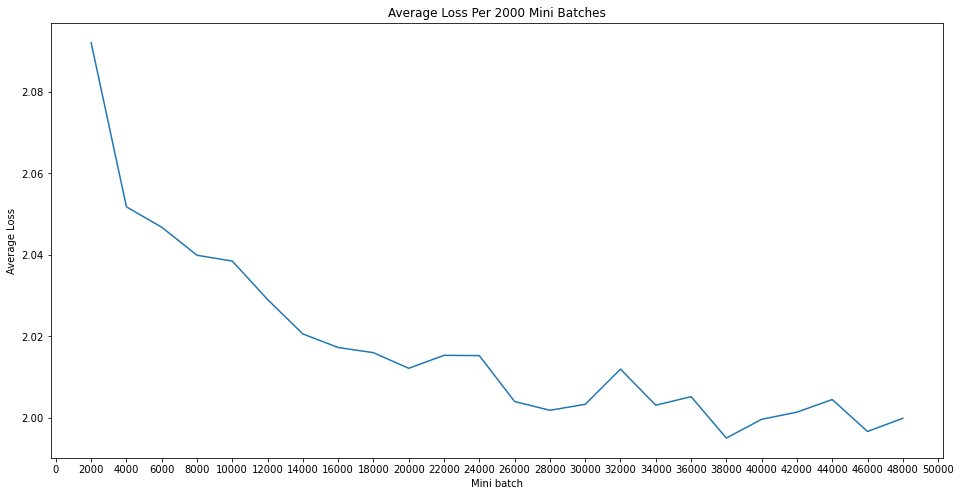

In [159]:
plot_loss(loss7)

### Softmax Regression

**Softmax vs logistic regression**

The softmax function computes the probability that a particular training sample belongs to each of the possible classes [(source)](https://en.wikipedia.org/wiki/Softmax_function). On the other hand, logistic regression will output the probability of the input belonging to a single class, rather than a probability distribution over all possible classes. This means that logistic regression requires one vs all or one vs one approach to adapt to work for data with more than two classes. In this way, softmax regression is better suited for multi class problems.

In [160]:
class SoftMaxRegression(nn.Module):
    def __init__(self):
        super(SoftMaxRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.flatten(x, 1)
        outputs = F.softmax(self.linear(x), dim=1)
        return outputs

Train model:

In [161]:
SMR = SoftMaxRegression()
criterion_smr = nn.CrossEntropyLoss()
optimizer_smr = optim.SGD(SMR.parameters(), lr=lr, momentum=momentum)
loss2 = trainer(SMR, criterion_smr, optimizer_smr)

[Epoch 1, Mini-batch  2000] Loss: 2.137
[Epoch 1, Mini-batch  4000] Loss: 2.101
[Epoch 1, Mini-batch  6000] Loss: 2.089
[Epoch 1, Mini-batch  8000] Loss: 2.075
[Epoch 1, Mini-batch 10000] Loss: 2.072
[Epoch 1, Mini-batch 12000] Loss: 2.071
[Epoch 2, Mini-batch  2000] Loss: 2.056
[Epoch 2, Mini-batch  4000] Loss: 2.054
[Epoch 2, Mini-batch  6000] Loss: 2.049
[Epoch 2, Mini-batch  8000] Loss: 2.051
[Epoch 2, Mini-batch 10000] Loss: 2.046
[Epoch 2, Mini-batch 12000] Loss: 2.052
[Epoch 3, Mini-batch  2000] Loss: 2.038
[Epoch 3, Mini-batch  4000] Loss: 2.045
[Epoch 3, Mini-batch  6000] Loss: 2.035
[Epoch 3, Mini-batch  8000] Loss: 2.039
[Epoch 3, Mini-batch 10000] Loss: 2.039
[Epoch 3, Mini-batch 12000] Loss: 2.041
[Epoch 4, Mini-batch  2000] Loss: 2.024
[Epoch 4, Mini-batch  4000] Loss: 2.034
[Epoch 4, Mini-batch  6000] Loss: 2.027
[Epoch 4, Mini-batch  8000] Loss: 2.035
[Epoch 4, Mini-batch 10000] Loss: 2.035
[Epoch 4, Mini-batch 12000] Loss: 2.036
Training time: 90.734897 seconds
Trainin

Evaluate model:

In [162]:
evaluate(SMR)

Accuracy of the network on the 10000 test images: 40.12 %


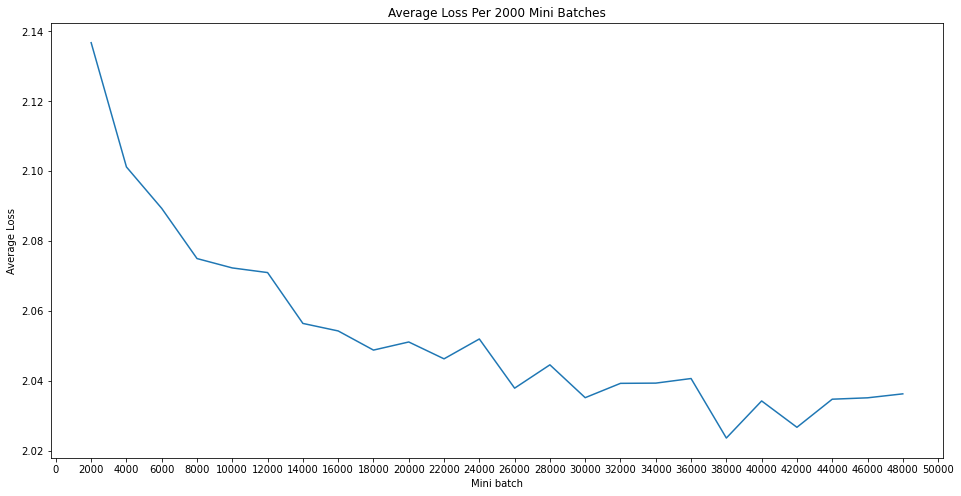

In [163]:
plot_loss(loss2)

#### Softmax Regression... with multiple linear layers??? (A neural network)

By adding layers, we can now create non-linear decision boundaries, which makes it possible to capture more complex patterns in the data. 

In [164]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024) 
        self.fc2 = nn.Linear(1024, 2048) 
        self.fc3 = nn.Linear(2048, 512)  
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x))
        x = self.fc4(x) 
        return torch.softmax(x, dim=1) 

Train model:

In [165]:
net = NN()
criterion_net = nn.CrossEntropyLoss()
optimizer_net = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
loss3 = trainer(net, criterion_net, optimizer_net)

[Epoch 1, Mini-batch  2000] Loss: 2.294
[Epoch 1, Mini-batch  4000] Loss: 2.207
[Epoch 1, Mini-batch  6000] Loss: 2.159
[Epoch 1, Mini-batch  8000] Loss: 2.118
[Epoch 1, Mini-batch 10000] Loss: 2.114
[Epoch 1, Mini-batch 12000] Loss: 2.090
[Epoch 2, Mini-batch  2000] Loss: 2.068
[Epoch 2, Mini-batch  4000] Loss: 2.069
[Epoch 2, Mini-batch  6000] Loss: 2.065
[Epoch 2, Mini-batch  8000] Loss: 2.063
[Epoch 2, Mini-batch 10000] Loss: 2.055
[Epoch 2, Mini-batch 12000] Loss: 2.047
[Epoch 3, Mini-batch  2000] Loss: 2.025
[Epoch 3, Mini-batch  4000] Loss: 2.030
[Epoch 3, Mini-batch  6000] Loss: 2.026
[Epoch 3, Mini-batch  8000] Loss: 2.029
[Epoch 3, Mini-batch 10000] Loss: 2.029
[Epoch 3, Mini-batch 12000] Loss: 2.029
[Epoch 4, Mini-batch  2000] Loss: 2.004
[Epoch 4, Mini-batch  4000] Loss: 2.003
[Epoch 4, Mini-batch  6000] Loss: 2.001
[Epoch 4, Mini-batch  8000] Loss: 2.016
[Epoch 4, Mini-batch 10000] Loss: 2.022
[Epoch 4, Mini-batch 12000] Loss: 2.002
Training time: 168.650806 seconds
Traini

Evaluate model:

In [166]:
evaluate(net)

Accuracy of the network on the 10000 test images: 44.91 %


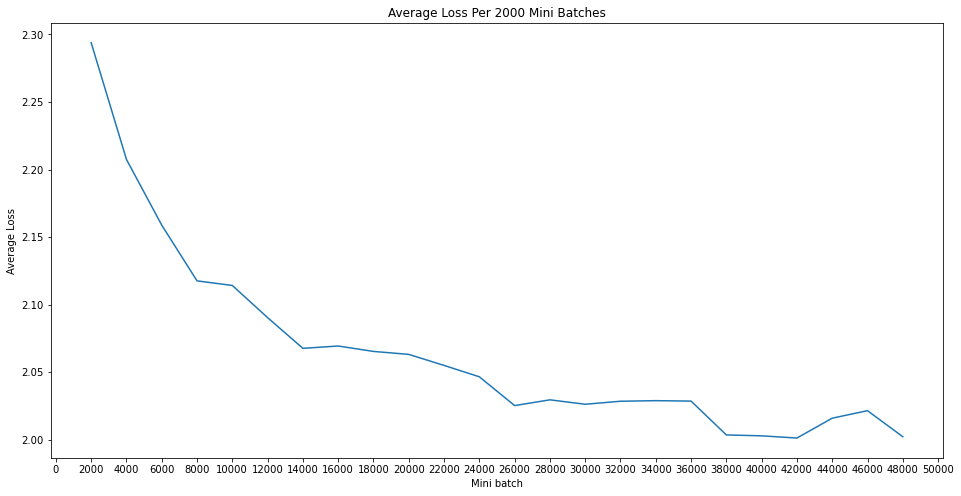

In [167]:
plot_loss(loss3)

### Analysis of the Section 2 Model Accuracies, Training Times, and Loss Graphs

Among the models tested in section 2, the most accurate was the softmax regression model with multiple layers. This model achieved an accuracy of 44.91% on the test set, which is the highest accuracy out of all the models in this section. Because this model is not strictly linear, it may not be appropriate to compare it directly to the other models in this section. However, it is still useful to report its performance here, as it offers insights into the effectiveness of more complex models.

The multiple layer model took approximately 168.65 seconds to train, which was the longest training time among the models in this section. This suggests that the added complexity of this model requires more training time to achieve high accuracy. 

Of the strictly linear models, the softmax regression model was the most accurate, achieving an accuracy of 40.12% on the test set. This model took 90.73 seconds to train, which is a little longer than the other two linear models. 

The logistic regression models were the least accurate, with the model with a bias term performing slightly better than the model without a bias term. The model with a bias term achieved an accuracy of 38.72% on the test set, whereas the model without a bias term had an accuracy of 38.25%. The fact that the model with a bias term only did slightly better than the model without a bias term suggests that while the optimal decision boundary likely does not pass directly through the origin, it probably passes close to the origin. The logistic regression model with a bias term and without a bias term took 84.2 and 85.18 seconds to train, respectively. That means that the logistic regression models had the fastest training times for the models in this section.

All of the models showed a similar trend in their loss graphs, with rapid initial improvement followed by a slower rate of improvement. By epoch four, each model seemed to be showing little improvement between mini batches. 

## Section 3: Convolutional Classifier
-------------------------------------------------
Perform the following tasks and report the differences. 
You must implement at least one CNN from scratch (build the class and forward methods)

- Implement, compare, and discuss multiple network architectures. E.g.: scratch vs ResNet vs AlexNet vs ...
- Compare different optimizers on a single classifier.
- Experiment with several DL techniques, such as: initialization, data augmentation (may use `torchvision` or `timm`), learning rate scheduling, ensembling, etc

#### A basic CNN from scratch!

Convolutional neural networks are useful for image classification tasks because they can learn and extract features from images using convolutional layers. On the other hand, traditional neural networks, such as the softmax regression with multiple layers model we made above, treat each pixel in an image as a separate input and do not consider the spatial structure of the image. 

Let's make our own CNN and compare its performance against the softmax regression model with multiple layers we evaluated earlier:

In [168]:
class ConvNet(nn.Module):
    """
    a simple convolutional neural network architecture for image classification.
    """
    def __init__(self):
        super().__init__()
        # Define the layers of the network
        self.conv1 = nn.Conv2d(3, 32, 3) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.norm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1152, 128) 
        self.fc2 = nn.Linear(128, 128) 
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        """
        the forward pass of the network
        """
        x = self.norm1(self.pool(F.relu(self.conv1(x)))) 
        x = self.norm2(self.pool(F.relu(self.conv2(x)))) 
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

Like we did for training our linear classifiers, we will use cross entropy loss for training our CNN.

In [169]:
cnn = ConvNet()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)
loss4 = trainer(cnn, criterion_cnn, optimizer_cnn)

[Epoch 1, Mini-batch  2000] Loss: 1.744
[Epoch 1, Mini-batch  4000] Loss: 1.465
[Epoch 1, Mini-batch  6000] Loss: 1.354
[Epoch 1, Mini-batch  8000] Loss: 1.286
[Epoch 1, Mini-batch 10000] Loss: 1.233
[Epoch 1, Mini-batch 12000] Loss: 1.171
[Epoch 2, Mini-batch  2000] Loss: 1.048
[Epoch 2, Mini-batch  4000] Loss: 1.043
[Epoch 2, Mini-batch  6000] Loss: 1.018
[Epoch 2, Mini-batch  8000] Loss: 0.999
[Epoch 2, Mini-batch 10000] Loss: 0.991
[Epoch 2, Mini-batch 12000] Loss: 0.990
[Epoch 3, Mini-batch  2000] Loss: 0.851
[Epoch 3, Mini-batch  4000] Loss: 0.850
[Epoch 3, Mini-batch  6000] Loss: 0.866
[Epoch 3, Mini-batch  8000] Loss: 0.840
[Epoch 3, Mini-batch 10000] Loss: 0.873
[Epoch 3, Mini-batch 12000] Loss: 0.864
[Epoch 4, Mini-batch  2000] Loss: 0.743
[Epoch 4, Mini-batch  4000] Loss: 0.766
[Epoch 4, Mini-batch  6000] Loss: 0.759
[Epoch 4, Mini-batch  8000] Loss: 0.780
[Epoch 4, Mini-batch 10000] Loss: 0.752
[Epoch 4, Mini-batch 12000] Loss: 0.771
Training time: 187.290513 seconds
Traini

In [170]:
evaluate(cnn)

Accuracy of the network on the 10000 test images: 70.43 %


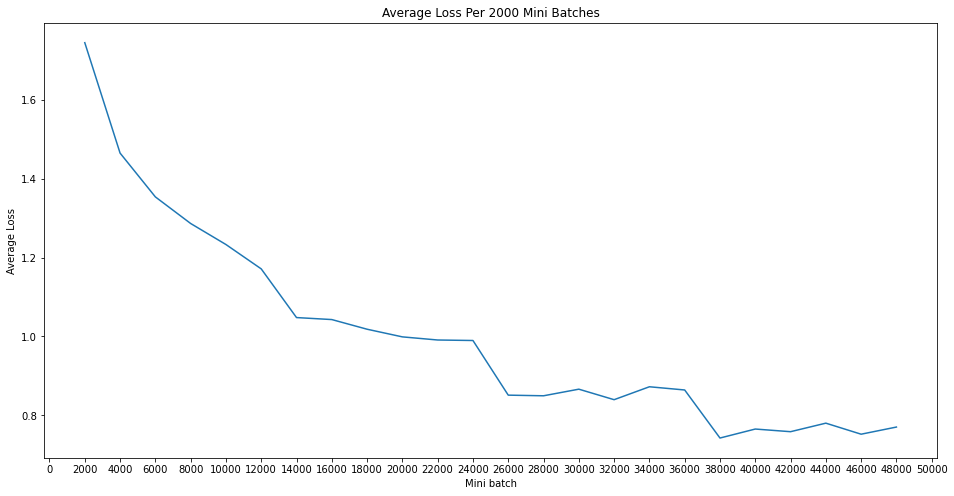

In [171]:
plot_loss(loss4)

### A simple ResNet

ResNet code based on following tutorial:
https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-mi

**What is a ResNet?**

ResNet's address the vanishing gradient problem by using residual connections between layers. In a residual connection, the output of a layer is added to the input of the layer to form a residual connection. By using residual connections, ResNet can train deeper neural networks without suffering from the vanishing gradient problems.

I will keep the hyperparameters similar to the CNN above to enable 1 to 1 comparison

In [172]:
# Define a helper function for creating a convolutional block
def conv_block(in_channels, out_channels, pool=False):
    # Define a list of layers for this block
    layers = [
        # Add a 2D convolution layer with a kernel size of 3 and padding of 1
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # Add a batch normalization layer to normalize the activations
        nn.BatchNorm2d(out_channels),   
        # Add a ReLU activation function
        nn.ReLU(inplace=True)
    ]
    
    # If the pool flag is set, add a 2D max pooling layer
    if pool: 
        layers.append(nn.MaxPool2d(2))
    # Return a sequential container containing the layers in this block
    return nn.Sequential(*layers)

# Define the main ResNet class
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        # Call the parent class's constructor
        super().__init__()
        # Add the first convolutional block
        self.conv = conv_block(in_channels, 32, pool=True)
        # Add the residual block
        self.res = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        self.norm = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(8192, 128) # fully connected layer with 120 outputs
        self.fc2 = nn.Linear(128, 128) # fully connected layer with 84 outputs
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Pass the input through the first convolutional block
        out = self.conv(x)
        # Pass the output through the first residual block and add the output to itself
        out = self.res(out) + out
        out = self.norm(F.relu(self.conv(x)))
        out = self.res(out) + out
        out = self.norm(F.relu(self.conv(x)))
        # Pass the output through the final classifier
        x = torch.flatten(out, 1)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) # apply third fully connected layer to produce the final output
        # Return the final output
        return x

In [173]:
resnet = ResNet(3, 10)
criterion_res_nn = nn.CrossEntropyLoss()
optimizer_res_nn = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum)
loss6 = trainer(resnet, criterion_res_nn, optimizer_res_nn)

[Epoch 1, Mini-batch  2000] Loss: 1.748
[Epoch 1, Mini-batch  4000] Loss: 1.530
[Epoch 1, Mini-batch  6000] Loss: 1.415
[Epoch 1, Mini-batch  8000] Loss: 1.351
[Epoch 1, Mini-batch 10000] Loss: 1.286
[Epoch 1, Mini-batch 12000] Loss: 1.231
[Epoch 2, Mini-batch  2000] Loss: 1.071
[Epoch 2, Mini-batch  4000] Loss: 1.060
[Epoch 2, Mini-batch  6000] Loss: 1.072
[Epoch 2, Mini-batch  8000] Loss: 1.049
[Epoch 2, Mini-batch 10000] Loss: 1.033
[Epoch 2, Mini-batch 12000] Loss: 1.038
[Epoch 3, Mini-batch  2000] Loss: 0.839
[Epoch 3, Mini-batch  4000] Loss: 0.854
[Epoch 3, Mini-batch  6000] Loss: 0.875
[Epoch 3, Mini-batch  8000] Loss: 0.871
[Epoch 3, Mini-batch 10000] Loss: 0.893
[Epoch 3, Mini-batch 12000] Loss: 0.889
[Epoch 4, Mini-batch  2000] Loss: 0.701
[Epoch 4, Mini-batch  4000] Loss: 0.708
[Epoch 4, Mini-batch  6000] Loss: 0.750
[Epoch 4, Mini-batch  8000] Loss: 0.762
[Epoch 4, Mini-batch 10000] Loss: 0.765
[Epoch 4, Mini-batch 12000] Loss: 0.763
Training time: 249.500868 seconds
Traini

In [174]:
evaluate(resnet)

Accuracy of the network on the 10000 test images: 64.17 %


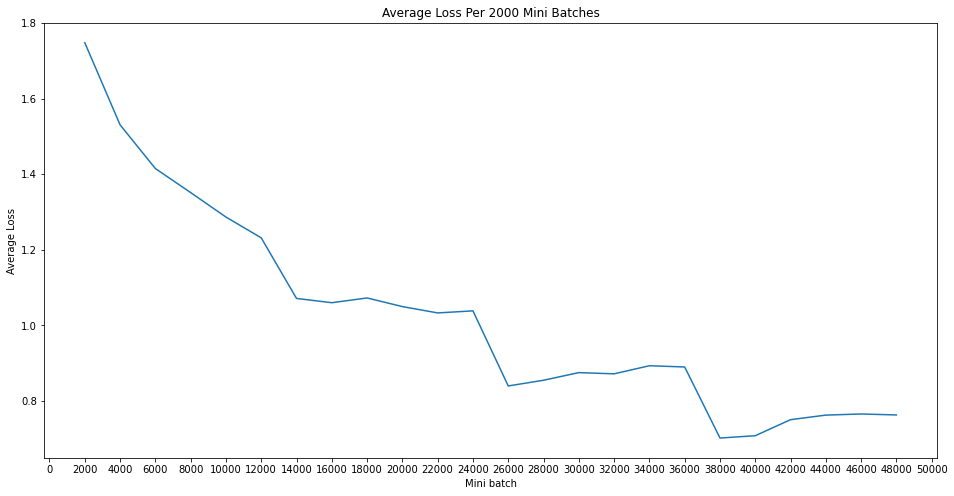

In [175]:
plot_loss(loss6)

#### What about a deeper (and wider) network?

In [176]:
class DeepCNN(nn.Module):
    """
    Deep(er) convolutional neural network architecture for image classification.
    """
    def __init__(self):
        super().__init__()
        # Define the layers of the network
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(64, 512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(512, 2048, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2) 
        
        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(512)
        self.norm3 = nn.BatchNorm2d(2048)
        
        self.fc1 = nn.Linear(32768, 1024) 
        self.fc2 = nn.Linear(1024, 256) 
        self.fc3 = nn.Linear(256, 128) 
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
    def forward(self, x):
        """
        the forward pass of the network
        """
        x = self.norm1(self.pool(F.relu(self.conv1(x)))) 
        x = self.norm2(self.pool(F.relu(self.conv2(x)))) 
        x = self.norm3(self.pool(F.relu(self.conv3(x)))) 
        
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x)) 
        x = self.fc5(x) 
        return x

In [177]:
deep = DeepCNN()
criterion_deep = nn.CrossEntropyLoss()
optimizer_deep = optim.SGD(deep.parameters(), lr=lr, momentum=momentum)
loss9 = trainer(deep, criterion_deep, optimizer_deep)

[Epoch 1, Mini-batch  2000] Loss: 1.752
[Epoch 1, Mini-batch  4000] Loss: 1.418
[Epoch 1, Mini-batch  6000] Loss: 1.289
[Epoch 1, Mini-batch  8000] Loss: 1.199
[Epoch 1, Mini-batch 10000] Loss: 1.132
[Epoch 1, Mini-batch 12000] Loss: 1.049
[Epoch 2, Mini-batch  2000] Loss: 0.925
[Epoch 2, Mini-batch  4000] Loss: 0.889
[Epoch 2, Mini-batch  6000] Loss: 0.878
[Epoch 2, Mini-batch  8000] Loss: 0.850
[Epoch 2, Mini-batch 10000] Loss: 0.854
[Epoch 2, Mini-batch 12000] Loss: 0.819
[Epoch 3, Mini-batch  2000] Loss: 0.662
[Epoch 3, Mini-batch  4000] Loss: 0.642
[Epoch 3, Mini-batch  6000] Loss: 0.664
[Epoch 3, Mini-batch  8000] Loss: 0.628
[Epoch 3, Mini-batch 10000] Loss: 0.634
[Epoch 3, Mini-batch 12000] Loss: 0.616
[Epoch 4, Mini-batch  2000] Loss: 0.434
[Epoch 4, Mini-batch  4000] Loss: 0.462
[Epoch 4, Mini-batch  6000] Loss: 0.465
[Epoch 4, Mini-batch  8000] Loss: 0.481
[Epoch 4, Mini-batch 10000] Loss: 0.486
[Epoch 4, Mini-batch 12000] Loss: 0.493
Training time: 877.478356 seconds
Traini

Let's evaluate our model:

In [178]:
evaluate(deep)

Accuracy of the network on the 10000 test images: 76.43 %


And plot the loss

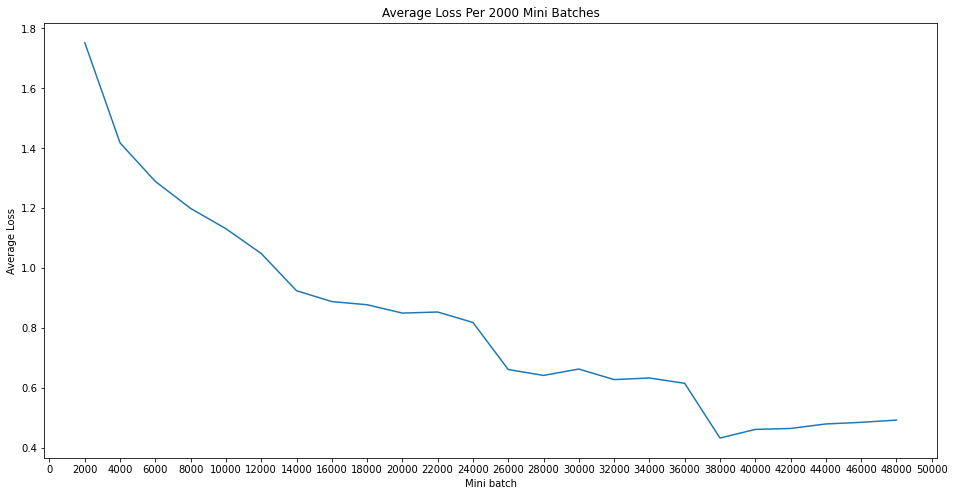

In [179]:
plot_loss(loss9)

#### Deep ResNet

Again, please note: ResNet code based on following tutorial:
https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

In [180]:
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.pool = nn.MaxPool2d(4)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(512, 1024) 
        self.fc2 = nn.Linear(1024, 256) 
        self.fc3 = nn.Linear(256, 10) 
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.pool(out)
        out = self.flatten(out)
        out = F.relu(self.fc1(out)) 
        out = F.relu(self.fc2(out)) 
        out = self.fc3(out) 
        return out

In [181]:
resnet9 = ResNet9(3, 10)
criterion_res9 = nn.CrossEntropyLoss()
optimizer_res9 = optim.SGD(resnet9.parameters(), lr=lr, momentum=momentum)
loss12 = trainer(resnet9, criterion_res9, optimizer_res9)

[Epoch 1, Mini-batch  2000] Loss: 1.926
[Epoch 1, Mini-batch  4000] Loss: 1.614
[Epoch 1, Mini-batch  6000] Loss: 1.475
[Epoch 1, Mini-batch  8000] Loss: 1.351
[Epoch 1, Mini-batch 10000] Loss: 1.230
[Epoch 1, Mini-batch 12000] Loss: 1.164
[Epoch 2, Mini-batch  2000] Loss: 1.061
[Epoch 2, Mini-batch  4000] Loss: 1.012
[Epoch 2, Mini-batch  6000] Loss: 0.930
[Epoch 2, Mini-batch  8000] Loss: 0.918
[Epoch 2, Mini-batch 10000] Loss: 0.918
[Epoch 2, Mini-batch 12000] Loss: 0.895
[Epoch 3, Mini-batch  2000] Loss: 0.752
[Epoch 3, Mini-batch  4000] Loss: 0.752
[Epoch 3, Mini-batch  6000] Loss: 0.751
[Epoch 3, Mini-batch  8000] Loss: 0.736
[Epoch 3, Mini-batch 10000] Loss: 0.731
[Epoch 3, Mini-batch 12000] Loss: 0.703
[Epoch 4, Mini-batch  2000] Loss: 0.617
[Epoch 4, Mini-batch  4000] Loss: 0.615
[Epoch 4, Mini-batch  6000] Loss: 0.605
[Epoch 4, Mini-batch  8000] Loss: 0.609
[Epoch 4, Mini-batch 10000] Loss: 0.574
[Epoch 4, Mini-batch 12000] Loss: 0.602
Training time: 436.167016 seconds
Traini

Evaluate our deep ResNet:

In [182]:
evaluate(resnet9)

Accuracy of the network on the 10000 test images: 79.07 %


Plot loss:

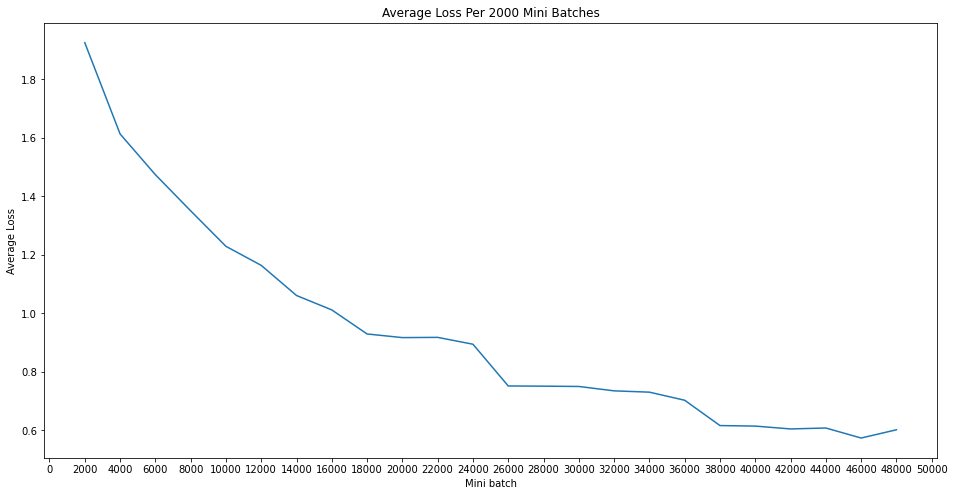

In [183]:
plot_loss(loss12)

### Bonus: Tuning Pytorch's ResNet-50 for cifar-10

In [184]:
# load the pretrained ResNet50 model with default weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# replace the final fully connected layer with a layer with the desired output dimension
model.fc = nn.Linear(model.fc.in_features, output_dim)

# iterate over the model parameters
for name, param in model.named_parameters():
    # if the parameter is not in the final fully connected layer
    if 'fc' not in name:
        # set requires_grad to False, indicating that these parameters 
        # do not require gradients to be computed during the backward 
        # pass of the optimization algorithm
        param.requires_grad = False

Yes, what you are seeing below is an image of the training time. I do not want to accidentally train this one again.

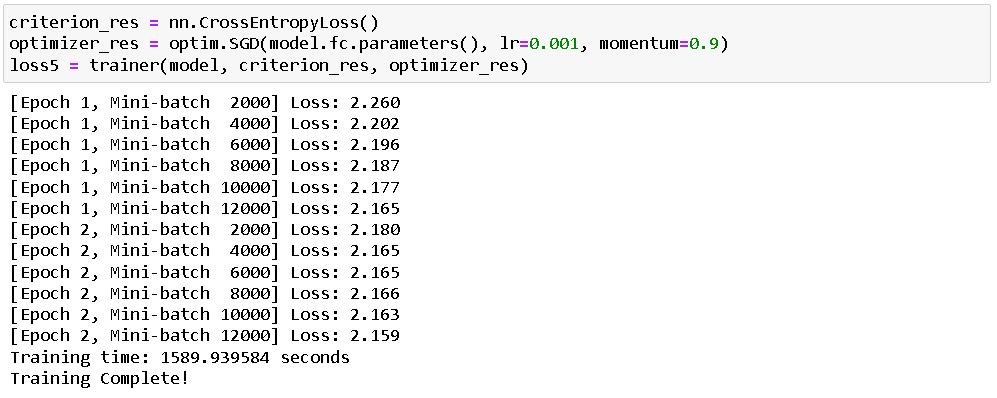

I trained this on my CPU...

In [185]:
# Load the saved weights into the model
model.load_state_dict(torch.load('resnet_weights.pth'))

<All keys matched successfully>

In [186]:
evaluate(model)

Accuracy of the network on the 10000 test images: 26.66 %


It did pretty bad... But still better than random guessing!

Below are the loss values from the training process:

In [187]:
loss5 = [2.259915750563145,
 2.20197591394186,
 2.1964772061109543,
 2.18735705190897,
 2.176630131602287,
 2.164537190079689,
 2.179586515724659,
 2.1650178663134576,
 2.1651071285009382,
 2.1658653237223624,
 2.1629934247136116,
 2.1589071660041808]

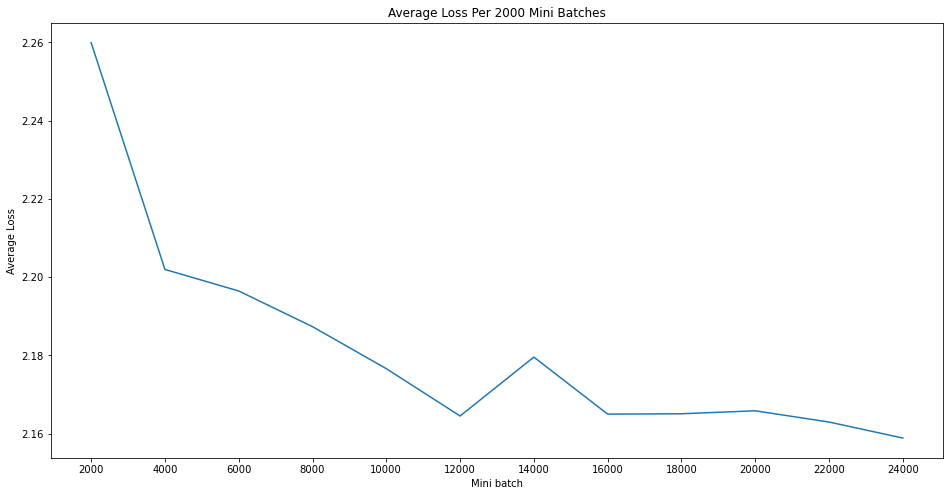

In [188]:
plot_loss(loss5)

### Analysis of the Convolutional Classifiers

The deep(er) ResNet achieved the highest accuracy at just over 79%, with the deep(er) CNN following closely behind at 76.43%. Despite their comparable performance, the deep(er) ResNet trained much faster than the deep(er) CNN, with a training time of 436 seconds compared to the deep(er) CNN's 877 seconds.

In contrast, the shallow CNN outperformed the shallow ResNet, achieving an accuracy of just over 70% on the test set, while the shallow ResNet achieved an accuracy of just over 64%.

The better performance of the deep(er) ResNet over the deep(er) CNN may be due to the residual connections in the ResNet model. Residual connections can help address the vanishing gradient problem that can arise in neural networks by allowing for easier flow of information through the network and improving performance. 

On the other hand, the shallower CNN outperformed the shallow ResNet. This may be because the shallower ResNet is not deep enough to fully take advantage of the benefits of residual connections.

## Section 4: Fine Tuning:
----------------------------------------
Fine tune a ResNet-50 model, pretrained on Imagenet, for classifying the [Caltech-UCSD Birds Dataset](http://www.vision.caltech.edu/visipedia/CUB-200.html)

**Strategy**

Fine-tuning the pre-trained ResNet50 model for classifying birds from the Caltech Birds dataset is an example of transfer learning. The pre-trained model has already learned to extract features from the imagenet data set and has achieved high accuracy when classifying images. 

We can fine tune this model by replacing the last fully connected layer of the pre-trained model with a new layer that has the number of output classes for the Caltech Birds dataset. Then, we can train the weights of the new layer on the Caltech Birds dataset. By doing so, the model can learn some of the features that are specific to the Caltech Birds dataset while still retaining many of the features learned from the pre-trained model. This can reduce the time we would spend training and (hopefully) improve model performance.

In [21]:
import os
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import save_model_dict, save_model_full, unpickle
from cub_tools.transforms import makeDefaultTransforms
from torchvision import datasets

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [25]:
root_dir = 'data'
data_path = os.path.join(root_dir,'CUB_200_2011')

In [57]:
# get data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
# set the batch size for the data loaders
batch_size = 32

# create the dataset object
dataset = ImageFolder(os.path.join(data_path, 'images'), transform=data_transforms)

# load the train/test split file
split_file = os.path.join(data_path, 'train_test_split.txt')
with open(split_file, 'r') as f:
    lines = f.readlines()

In [104]:
# create lists to store the image IDs and the labels
train_image_ids = []
test_image_ids = []
train_labels = []
test_labels = []

# loop over the lines of the split file and assign each image to train or test set
for line in lines:
    # extract the image ID and whether it is a training image or not from the current line
    image_id, is_training_image = line.strip().split(' ')
    
    # convert the image ID and training indicator to integers
    image_id = int(image_id)
    is_training_image = int(is_training_image)
    
    # this image is dumb (mislabelled or doesn't exist or something)
    if image_id == 11788:
        continue
    
    # if the image is a training image, add its ID to the train set and its label to the train labels
    if is_training_image:
        train_image_ids.append(image_id)
        train_labels.append(dataset.targets[image_id])
    
    # if the image is a test image, add its ID to the test set and its label to the test labels
    else:
        test_image_ids.append(image_id)
        test_labels.append(dataset.targets[image_id])

In [105]:
len(set(train_labels))

200

In [106]:
# split the dataset into train and test subsets
train_dataset = torch.utils.data.Subset(dataset, train_image_ids)
test_dataset = torch.utils.data.Subset(dataset, test_image_ids)

# create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [111]:
# load the pretrained ResNet50 model with default weights
weights = ResNet50_Weights.DEFAULT
model_birds = resnet50(weights=weights)

num_classes = 200 # number of classes in the Caltech-UCSD Birds dataset
model_birds.fc = nn.Linear(in_features=2048, out_features=num_classes)

# Iterate over the model parameters
for name, param in model_birds.named_parameters():
    # If the parameter is not in the final fully connected layer
    if 'fc' not in name:
        # set requires_grad to False, indicating that these parameters 
        # do not require gradients to be computed during the backward 
        # pass of the optimization algorithm
        param.requires_grad = False

In [112]:
criterion_birds = nn.CrossEntropyLoss()
optimizer_birds = optim.SGD(model_birds.parameters(), lr=lr, momentum=momentum)

Train model:

In [113]:
start = time.perf_counter() 
loss_history = []

model_birds = model_birds.to(device)
criterion_birds = criterion_birds.to(device)
for epoch in range(30): 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_birds.zero_grad()
        outputs = model_birds(inputs)
        loss = criterion_birds(outputs, labels)
        loss.backward()
        optimizer_birds.step()
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[Epoch: %d, Batch: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_history.append(running_loss / 100)
            running_loss = 0.0  
            
end = time.perf_counter()
# print the training time
print(f"Training time: {end - start:.6f} seconds")

[Epoch: 1, Batch:   100] loss: 5.263
[Epoch: 2, Batch:   100] loss: 4.981
[Epoch: 3, Batch:   100] loss: 4.718
[Epoch: 4, Batch:   100] loss: 4.473
[Epoch: 5, Batch:   100] loss: 4.228
[Epoch: 6, Batch:   100] loss: 4.036
[Epoch: 7, Batch:   100] loss: 3.845
[Epoch: 8, Batch:   100] loss: 3.662
[Epoch: 9, Batch:   100] loss: 3.494
[Epoch: 10, Batch:   100] loss: 3.353
[Epoch: 11, Batch:   100] loss: 3.191
[Epoch: 12, Batch:   100] loss: 3.065
[Epoch: 13, Batch:   100] loss: 2.966
[Epoch: 14, Batch:   100] loss: 2.857
[Epoch: 15, Batch:   100] loss: 2.754
[Epoch: 16, Batch:   100] loss: 2.649
[Epoch: 17, Batch:   100] loss: 2.550
[Epoch: 18, Batch:   100] loss: 2.489
[Epoch: 19, Batch:   100] loss: 2.403
[Epoch: 20, Batch:   100] loss: 2.323
[Epoch: 21, Batch:   100] loss: 2.278
[Epoch: 22, Batch:   100] loss: 2.226
[Epoch: 23, Batch:   100] loss: 2.143
[Epoch: 24, Batch:   100] loss: 2.084
[Epoch: 25, Batch:   100] loss: 2.046
[Epoch: 26, Batch:   100] loss: 1.960
[Epoch: 27, Batch:   

Evaluate the model:

In [114]:
model_birds = model_birds.to(device) 
model_birds.eval()  

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        images = images.to(device)  
        labels = labels.to(device)  
                
        outputs = model_birds(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the network on the birds test set: {100 * correct / total:.2f} %')

Accuracy of the network on the birds test set: 49.42 %


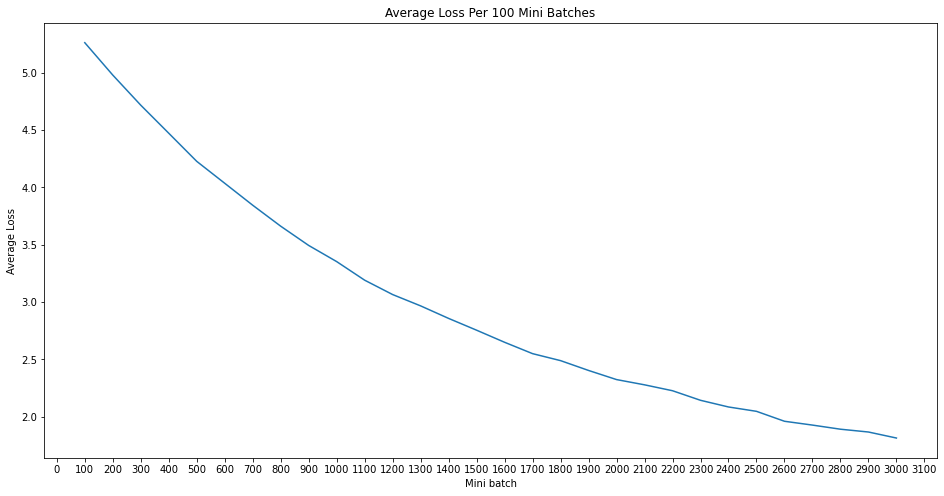

In [115]:
fig, ax = plt.subplots(figsize=(16,8))
x = np.arange(0, len(loss_history))

ax.plot(x, loss_history)
# get the current x limits
x_lim = ax.get_xlim()
# generate a list of tick positions 
new_ticks = [x for x in range(int(x_lim[0]), int(x_lim[1] + 1))]
# divide the tick positions by 100 and convert them to strings
new_labels = [str((x+1) * 100) for x in new_ticks]
# set the new x tick positions and labels
ax.set_xticks(new_ticks)
ax.set_xticklabels(new_labels)
plt.title("Average Loss Per 100 Mini Batches")
plt.xlabel("Mini batch")
plt.ylabel("Average Loss")
plt.show()

### Analysis

The Caltech Birds dataset has 200 classes, which makes it a more challenging data set to classify than CIFAR-10 (I assume). Thus, achieving an accuracy of over 49% on the test set is a good performance, given the number of classes and the complexity of the dataset. Additionally, the training time for the fine-tuned ResNet50 model was just under 770 seconds, which is relatively fast considering the depth and complexity of the model we used.

I feel like these results are a good example of the potential benefits of transfer learning. By leveraging the pre-trained model's knowledge and using it as a starting point, we were able to achieve good accuracy on the Caltech Birds dataset while significantly reducing the training time and required data!

## Extra Credit: k-NN 
-----------------------------------
Implement, using pytorch, a k-NN classifier.
Compare the differences when using L1 vs L2 difference.
Use multiple values for k, e.g.: 1, 3, 5, 10.
Compare the differences for speed and accuracy

Let's start by preparing our training and testing sets. The below code prepares the training testing data and labels by formatting the input images into flattened tensors with matching labels.

In [98]:
train_data = []
train_labels = []
for data in trainloader:
    images, labels = data
    images = images.squeeze()
    train_data.append(images)
    train_labels.extend(labels)
    
train_data = torch.cat(train_data, dim=0)
train_data = train_data.reshape(train_data.shape[0], -1)
train_labels = torch.tensor(train_labels)
train_data.size(), train_labels.size()

(torch.Size([50000, 3072]), torch.Size([50000]))

In [103]:
test_data = []
test_labels = []
for data in testloader:
    images, labels = data
    images = images.squeeze()
    test_data.append(images)
    test_labels.extend(labels)
test_data = torch.cat(test_data, dim=0)
test_data = test_data.reshape(test_data.shape[0], -1)
test_labels = torch.tensor(test_labels)
test_data.size(), test_labels.size()

(torch.Size([10000, 3072]), torch.Size([10000]))

### K-NN Algorithm


**What is it?**
Now let's define our K-NN algorithm. K-Nearest Neighbors (K-NN) is a classification algorithm that does not learn a specific function from the training data in the way that algorithms like neural networks do. Instead, KNN classifies new observations by searching through the training set to find the K closest observations, based on some distance metric. The class label of the new observation is then predicted based on the most frequent class label among its K nearest neighbors. In other words, K-NN predicts the class of a data point based on the classes of its nearest neighbors.

**Do I think it will work?**
I suspect that K-NN will not be much more accurate on the CIFAR-10 test set than random guessing. I think that the patterns in the data will be too complex to be captured by such a simple algorithm.


Let's implement K-NN using PyTorch:

In [ ]:
class KNN:
    """
    K-Nearest Neighbors classifier
    """
    def __init__(self, k=5, distance='l2'):
        self.k = k
        self.distance = distance

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        X = X.to(device)
        if self.distance == 'l1':
            y_pred = self._predict_l1(X)
        else:
            y_pred = self._predict_l2(X)
        return y_pred

    def _predict_l1(self, x):
        distances = torch.sum(torch.abs(x - self.X_train), dim=1)
        k_indices = torch.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]
        return torch.mode(k_labels).values.item()

    def _predict_l2(self, x):
        distances = torch.sqrt(torch.sum((x - self.X_train) ** 2, dim=1))
        k_indices = torch.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]
        return torch.mode(k_labels).values.item()

In [129]:
def evaluate_knn(model, test_data, test_labels):
    """
    Function to evaluate a KNN model
    """
    start = time.perf_counter() 
    correct = 0
    total = 0
    # move data to device
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    # Iterate over each test sample
    for i in range(len(test_data)):
        x = test_data[i]
        y = test_labels[i]
        # Get the predicted label for the current sample
        y_pred = model.predict(x)
        # Check if the predicted label matches the true label
        if y_pred == y:
            correct += 1
        total += 1
    # Calculate and return the accuracy of the model
    accuracy = correct / total
    end = time.perf_counter()
    print(f"Evaluation time: {end - start:.6f} seconds")
    return accuracy

### Taking a random sample of the test set

Evaluation ended up being very slow on the full test set, so I opted to use a random subset of the test set to speed stuff up. I chose a test set sample of size=100 because the evaluation time ended up being about a minute (not too painful).

In [108]:
n = len(test_data)
random_indices = np.random.choice(n, size=100, replace=False)
test_data_sample = test_data[random_indices]
test_labels_sample = test_labels[random_indices]
len(test_data_sample), len(test_labels_sample)

(100, 100)

### Evaluation

Let's evaluate our k-nn algorithm when k=1 and the distance function is L1:

In [111]:
knn_k1_l1 = KNN(k=1, distance="l1")
knn_k1_l1.fit(train_data, train_labels)
accuracy_k1_l1 = evaluate_knn(knn_k1_l1, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k1_l1:.2f}")

Evaluation time: 125.886685 seconds
Test accuracy: 0.44


Now let's evaluate our k-nn algorithm when k=1 and the distance function is L2:

In [112]:
knn_k1_l2 = KNN(k=1)
knn_k1_l2.fit(train_data, train_labels)
accuracy_k1_l2 = evaluate_knn(knn_k1_l2, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k5_l1:.2f}")

Evaluation time: 78.871156 seconds
Test accuracy: 0.17


Let's evaluate our k-nn algorithm when k=3 and the distance function is L1:

In [113]:
knn_k3_l1 = KNN(k=3, distance="l1")
knn_k3_l1.fit(train_data, train_labels)
accuracy_k3_l1 = evaluate_knn(knn_k3_l1, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k3_l1:.2f}")

Evaluation time: 128.519067 seconds
Test accuracy: 0.37


Now let's evaluate our k-nn algorithm when k=3 and the distance function is L2:

In [114]:
knn_k3_l2 = KNN(k=3)
knn_k3_l2.fit(train_data, train_labels)
accuracy_k3_l2 = evaluate_knn(knn_k3_l2, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k3_l2:.2f}")

Evaluation time: 77.203708 seconds
Test accuracy: 0.37


Let's evaluate our k-nn algorithm when k=5 and the distance function is L1:

In [115]:
knn_k5_l1 = KNN(distance="l1")
knn_k5_l1.fit(train_data, train_labels)
accuracy_k5_l1 = evaluate_knn(knn_k5_l1, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k5_l1:.2f}")

Evaluation time: 129.377649 seconds
Test accuracy: 0.44


Now let's evaluate our k-nn algorithm when k=5 and the distance function is L2:

In [116]:
knn_k5_l2 = KNN()
knn_k5_l2.fit(train_data, train_labels)
accuracy_k5_l2 = evaluate_knn(knn_k5_l2, test_data_sample, test_labels_sample)
print(f"Test accuracy: {accuracy_k5_l2:.2f}")

Evaluation time: 57.079841 seconds
Test accuracy: 0.36


### Analysis

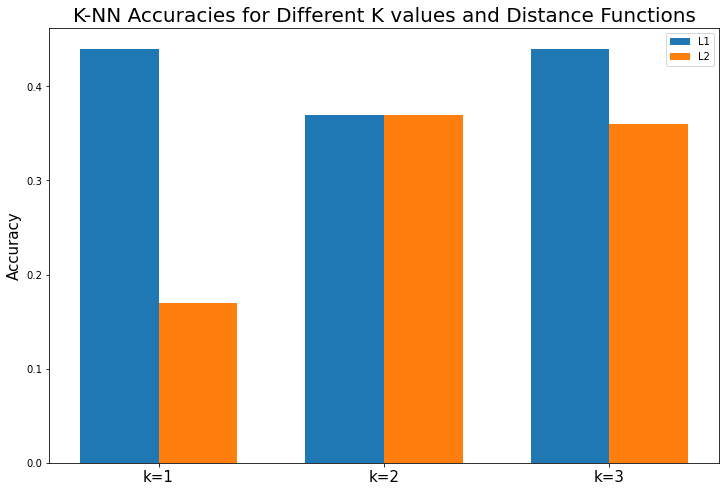

In [128]:
N = 3
l1_accuracies = (0.44, 0.37, 0.44)
l2_accuracies = (0.17, 0.37, 0.36)
ind = np.arange(N)  
width = 0.35      

# Plot the data
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(ind - width/2, l1_accuracies, width, label='L1')
rects2 = ax.bar(ind + width/2, l2_accuracies, width, label='L2')

ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title('K-NN Accuracies for Different K values and Distance Functions', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(('k=1', 'k=2', 'k=3'), fontsize=15)
ax.legend();

#### I am willing to admit that I was wrong...

K-NN performed surprisingly well for classifying images in the CIFAR-10 dataset. Most models, regardless of the K value or distance function used, achieved an accuracy of more than 35% on the test set, which is quite good.

#### A noteworthy result
The K-NN models that used the L1 difference function produced higher accuracy than models that used L2.

*Why might this be?*

The L2 distance function calculates the square root of the sum of squared differences between two points. In image classification, the two points represent the pixel values of two images being compared. Because the squared differences are being summed, larger differences between pixel values are weighted more heavily, leading to greater overall differences between images.

On the other hand, the L1 distance function calculates the sum of the absolute differences between two points. This means that all differences are weighted equally, regardless of their magnitude. In image classification, differences in individual pixel values will have less impact on the overall distance between images.

#### Limitations
I did not evaluate the K-NN models on the entire test set, which limits the conclusions that we can draw about their accuracy compared to other models that were evaluated on the whole test set.